**Introduction:**

Heart disease remains a pervasive threat to public health in the United States, claiming numerous lives annually. Statistics reveal that 1 in every 5 individuals is susceptible to this condition, underscoring its significant impact on society (American Heart Association, 2020). Recognizing the urgency of addressing this health concern, we endeavor to develop a predictive model capable of assessing the severity of heart conditions. Leveraging a comprehensive dataset on heart disease, comprising 297 instances, our project aims to accurately classify the risk levels associated with various physiological variables (Lin et al., 2013). By doing so, we aspire to empower individuals with valuable insights into their cardiovascular health status.

**Method and Results**

Before we start doing any kind of work with our data, we need to load our neccesary libraries. These libraries contain the neccesary packages that will allow us to process, mutate, and eventually for presenting our data.

In [1]:
library(dplyr)
library(tidyr) #Loading all libraries 
library(forcats)
library(purrr)
library(readr)
library(ggplot2)
library(cowplot)
library(repr)
library(tidyverse)
library(tidymodels)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
Warning message:
“package ‘cowplot’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ stringr   1.5.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workfl

**Loading Data from Web**

Due to the original dataset being packaged in a ".zip" file, we needed to extract the package locally first. For this project, we decided on the Cleveland dataset, as it best represents our capabilities and skills. Then, we uploaded our selected dataset onto Github, which would allow us to download the document onto this notebook. We used the URL containing the raw document for our purposes. In combination with the download.file command, we were able to load the dataset from the web


In [2]:
download.file("https://raw.githubusercontent.com/000557A/WebDataSet/main/processed.cleveland.data",
              "Data/unprocessed.cleveland.data")

**Preliminary Cleaning of Data**

As indicated by the UC Irvine Machine Learning Repository (Where this dataset originated from), we know that this dataset has some missing columns. In the table included on the website, we see that the "ca" and "thal" variables contain missing values. A quick glance at our dataset allowed us to see that the placeholder values were indicated with a "?".

Another aspect of this dataset is the missing column names. We retrieved the list of variables form the UC Irvine Repository, and added them back to our dataset.

We have also decided to mutate each variable as a factor. This would allow us to ... (NOT FINISHED)

In [3]:
heart_data <- read_delim("Data/processed.cleveland.data", delim = ",",
          col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak" , "slope", "ca", "thal", "num")
                        )|> filter(ca != '?' , thal != "?") |>
mutate("sex" = as.factor(sex),
       "cp" = as.factor(cp),
       "fbs" = as.factor(fbs),
       "restecg" = as.factor(restecg),
       "exang" = as.factor(exang),
      "num" = as.factor(num))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


At this step, we also noticed that our dataset was still saved as a ".data" file, rather than the commonly used ".csv". Through this discovery, we converted our processed dataset into a csv file.

In [4]:
write.csv(heart_data, "Data/data.csv")

When we finally opened our newly created file, we realized that the first column was not something we wanted to keep. It contained the numbers that each row corresponded to, thus it was removed through "select"

In [5]:
bob <- read_csv("Data/data.csv")|>
        select(age,trestbps,chol,thalach,num)

New names:
• `` -> `...1`
Rows: 297 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (15): ...1, age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Creating Summary of Data**

After our preliminary data processing, we were now ready to create summaries for our data. Many of the variables were irrelevent for our research, so we excluded them in our summarization table. As a group, we believed it was important to find the average age, resting blood pressure, serum colestoral levels, and maximum heart rate achieved. Aside from these variables, we also wanted to know how much data we had, thus we included the total observation count. 

In [6]:
heart_data_mean <-bob |>
map_df(mean)|>
mutate("Observation Count" = nrow(bob)) |>
select(age,trestbps,chol,thalach,num,"Observation Count")

#The actual table
heart_data_mean


age,trestbps,chol,thalach,num,Observation Count
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
54.54209,131.6936,247.3502,149.5993,0.9461279,297


**Performing Data Analysis**

Before we start doing any kind classification, we need to split the data into 2 segments, a training set and a testing set.


In [39]:
set.seed(727)

heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

After we split the data, we MUST scale and center our data. This is because K-Nearest Neighbor classification relies heavily on the scale of the predictors.

Since we are predicting the severity of the heart disagnostic based on age, resting heartbeat, etc. , we need to include these things in our recipe too.

In [40]:
heart_recipe <- recipe(num ~ age + trestbps + chol + thalach , data = heart_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

Since we don't exactly know what number of neighors to use yet, lets just test a range between 2 neighors and 20.

In [41]:
kvalues <- tibble(neighbors = seq(from = 2, to = 21, by = 1))

In order to ensure that our data is easily reproducible, we need to set a seed.

For this project, we decided on setting the seed as 727.

Since we are using KNN classification, it is important to find the best number of neighbors for classification.
In order to do this, we will use 5-fold-cross-validation.

The following code will be used to determine the optimal number of neighors used for this approximation


In [42]:
set.seed(727)

heart_vfold <- vfold_cv (heart_train, v = 5, strata = 4)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
            set_engine("kknn")|>
            set_mode ("classification")

heart_wkfl <- workflow ()|>
            add_model(knn_tune)|>
            add_recipe(heart_recipe)|>
            tune_grid(resamples = heart_vfold, grid = kvalues)|>
            collect_metrics()



In order to see the accuracy each K value gives, we need to filter our workflow to only contain the accuracy.

In [43]:
accuracy_data <- heart_wkfl |>
            filter(.metric == "accuracy")


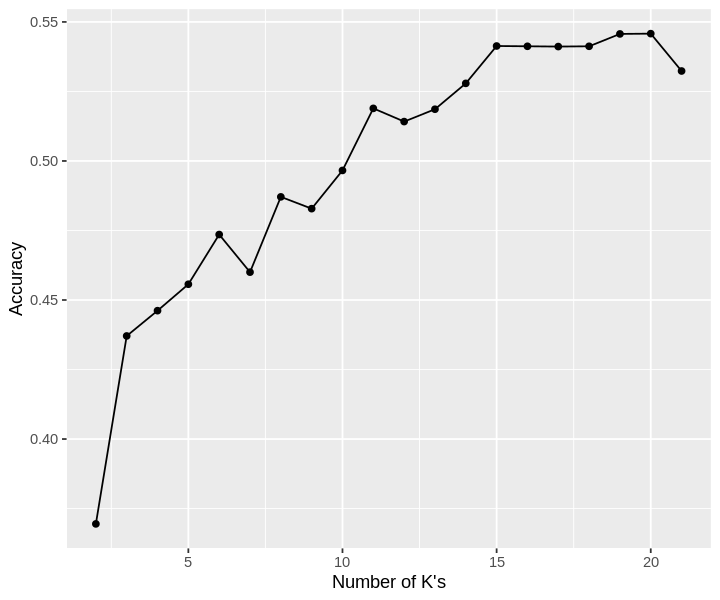

In [44]:
options(repr.plot.height = 5, repr.plot.width = 6)
# This top part is to make the graph fit the screen better

cross_val_plot <- accuracy_data |>
    ggplot(aes (x = neighbors, y = mean))+
    geom_point()+
    geom_line(aes(x = neighbors, y = mean))+
    xlab("Number of K's")+
    ylab ("Accuracy")

cross_val_plot

Looking at this graph, we see that the best number of neighbors is 20.

Therefore, we will proceed with this project using 20 neighbors for classification.


In [50]:
set.seed(727)


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(knn_spec) |>
       fit(data = heart_train)






**Testing the Accuracy of our KNN Classifier**


In [51]:
heart_accuracy <- predict(heart_fit, heart_test) |>
    bind_cols(heart_test)|>
  metrics(truth = num, estimate = .pred_class)|>
  filter(.metric == "accuracy")

heart_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5733333


**Summary of Findings**:
Relationship between Variables and Heart Disease: The histograms reveal varying distributions of age, cholesterol, maximum heart rate, and resting blood pressure across different levels of heart disease severity. This indicates a potential correlation between these variables and the presence or severity of heart disease.
Modeling Approach: The proposed method of using K-nearest neighbors (KNN) for classification based on age, cholesterol, maximum heart rate, and resting blood pressure seems reasonable given the observed patterns in the data.


**Expectations vs. Findings**:
The findings largely align with expectations. The visualizations show clear trends suggesting that the selected variables could indeed be useful for predicting heart disease severity. However, the exact degree of predictive power and the optimal K value for the KNN model may vary from initial expectations. Further analysis and model evaluation will provide a clearer picture.

**Potential Impact**:
The findings from this study could have significant implications for healthcare and medical practice:

Personalized Care: Identifying individuals at higher risk of heart disease based on predictive models could enable healthcare professionals to offer more personalized preventive care and interventions.

Early Detection: Predictive models could aid in early detection of heart disease, allowing for timely medical interventions and lifestyle modifications to mitigate risks.
Real-time Monitoring: Integration of predictive models into wearable devices or health monitoring systems could facilitate real-time monitoring of heart health, leading to prompt interventions when abnormalities are detected.

**Future Research Questions:**

Feature Selection: Are there additional variables or features that could further improve the accuracy of heart disease prediction models?

Model Optimization: Would it be beneficial to tune the KNN model parameters for better performance in terms of recall or precision, especially considering the potential consequences of false positives or false negatives in heart disease prediction?

Generalizability: How well do the findings and predictive models generalize to broader populations beyond the dataset used in this study?

Longitudinal Analysis: How do changes in these variables over time correlate with changes in heart disease risk, and can predictive models be adapted for longitudinal monitoring?

**References:**

American Heart Association. (2020). Heart disease and stroke statistics—2020 update: A report from the American Heart Association. Circulation, 141(9), e139-e596.

Lin, W.-H., Zhang, H., & Zhang, Y.-T. (2013). Investigation on Cardiovascular Risk Prediction Using Physiological Parameters. Computational and Mathematical Methods in Medicine, 2013, 272691. https://doi.org/10.1155/2013/272691